In [1]:
import scvelo as scv
import scanpy as spy
import numpy as np  
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger

import seaborn as sns

matplotlib_axes_logger.setLevel('ERROR')
import json
import anndata

import cellpath as cp
import cellpath.visual as visual
import cellpath.benchmark as bmk 


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# CellPath core

In [2]:
# pre-clustered dataseet
adata = anndata.read_h5ad("./real_data/forebrain/fb_clust.h5ad")

AnnData object with n_obs × n_vars = 1720 × 1000 
    obs: 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'groups'
    var: 'means', 'dispersions', 'dispersions_norm', 'stochastic_gamma', 'stochastic_r2', 'stochastic_genes', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'neighbors', 'pca', 'stochastic_settings', 'velocity_graph', 'velocity_graph_neg', 'velocity_settings'
    obsm: 'X_pca', 'X_pre_pca', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'stochastic', 'unspliced', 'variance_stochastic', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [ ]:
cellpath_obj = cp.CellPath(adata = adata)
# self, n_clusters = None, include_unspliced = True, standardize = True, **kwarg
cellpath_obj.meta_cell_construction(n_clusters = 100, include_unspliced = True, standardize = True)
cellpath_obj.meta_cell_graph(k_neighs = 10, pruning = True)
cellpath_obj.meta_paths_finding(threshold = 0.5, cutoff_length = None, length_bias = 0.5, max_trajs = 30)
cellpath_obj.first_order_pt(num_trajs = None)

# Visualization

In [ ]:
visual.weight_histogram(cellpath_obj, resolution = 100)

In [ ]:
visual.plot_data(cellpath_obj, basis = "pca", figsize = (15,7), save_as = None, axis = False, colormap = "Paired", legend_pos = "upper right")

In [ ]:
visual.meta_traj_visual(cellpath_obj, basis = "pca", trajs = 4, figsize = (15,7), save_as = None, colormap = "tab20b", axis = True, legend_pos = "upper center")

In [ ]:
visual.first_order_approx_pt(cellpath_obj, basis="pca", trajs = 4, figsize = (20,15), save_as = None)

In [5]:
# number of clusters
clusters = 100
# number of trials
n_trials = 10
# cluster obj

# note that standardize should be set to False. or the result is not good.
clust.cluster_cells(adata, n_clusters = clusters, n_init = n_trials, include_unspliced = False, standardize=False)

X_cluster, velo_cluster = clust.meta_cells(adata)
groups = adata.obs['groups']

Already conducted clustering


make symmetric by pruning


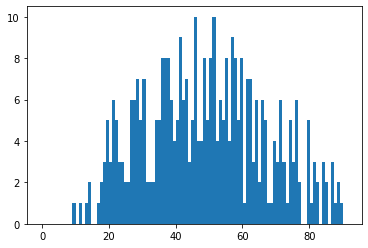

In [6]:
k = 10
adj_matrix,dist_matrix = nn.NeighborhoodGraph(X_cluster,k, symm = True)
adj_assigned, max_weight = nn.assign_weights(adj_matrix,dist_matrix, X_cluster, velo_cluster,scaling = 3,\
                              distance_scaler = 0.5,thresholding = 0.0)
visual.weight_histogram(adj_assigned, scaling=100,upper=max_weight)

In [7]:
paths, opt = path.dijkstra_paths(adj_assigned, indeg = [0,1,2])
clusters = int(np.max(groups)+1)
# greedy_paths, paths = path.greedy_selection(clusters, paths, opt, threshold = 0.5, max_w=max_weight, cut_off=5, verbose=True)
greedy_paths, paths = path.greedy_selection(clusters, paths, opt, threshold = 0.5, max_w=max_weight, cut_off=3, verbose=True, length_bias=0.5, max_trajs = 30)

cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  14_93 , len:  15 newly covered: 15
start_end:  25_29 , len:  10 newly covered: 9
start_end:  98_2 , len:  15 newly covered: 6
start_end:  27_0 , len:  9 newly covered: 7
start_end:  42_51 , len:  9 newly covered: 6
start_end:  50_69 , len:  7 newly covered: 6
start_end:  14_35 , len:  13 newly covered: 2
start_end:  14_39 , len:  11 newly covered: 2
start_end:  14_23 , len:  13 newly covered: 1
Finished


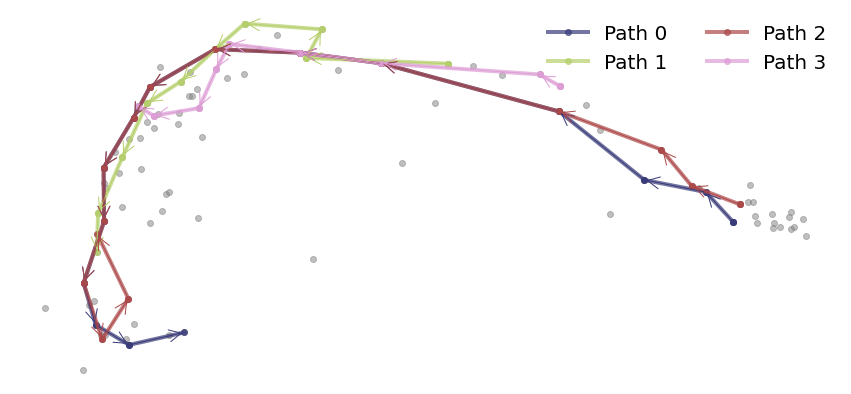

In [8]:
trajs = 4
visual.meta_traj_visual(X_cluster, paths, greedy_paths, trajs = trajs, figsize = (15,7), axis = False, save_as = None)#"./real_results/forebrain/umap_clust_paths.pdf")

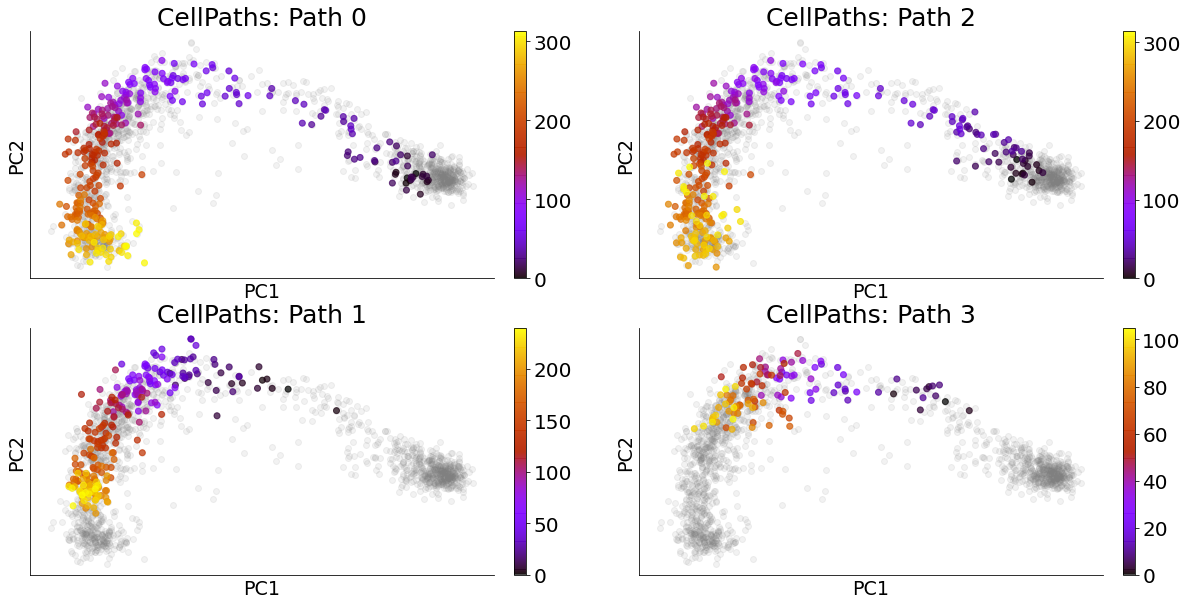

In [9]:
pseudo_order = visual.first_order_approx_pt(adata, paths, greedy_paths, X_cluster, velo_cluster, basis = 'pca', groups = None, trajs = trajs, figsize= (20,10), save_as = None)#"./real_results/forebrain/first_order_approx_pt.pdf")

# Differentially expressed genes

In [10]:
de_genes = de.de_analy(adata, pseudo_order, p_val_t = 0.05, verbose=False)

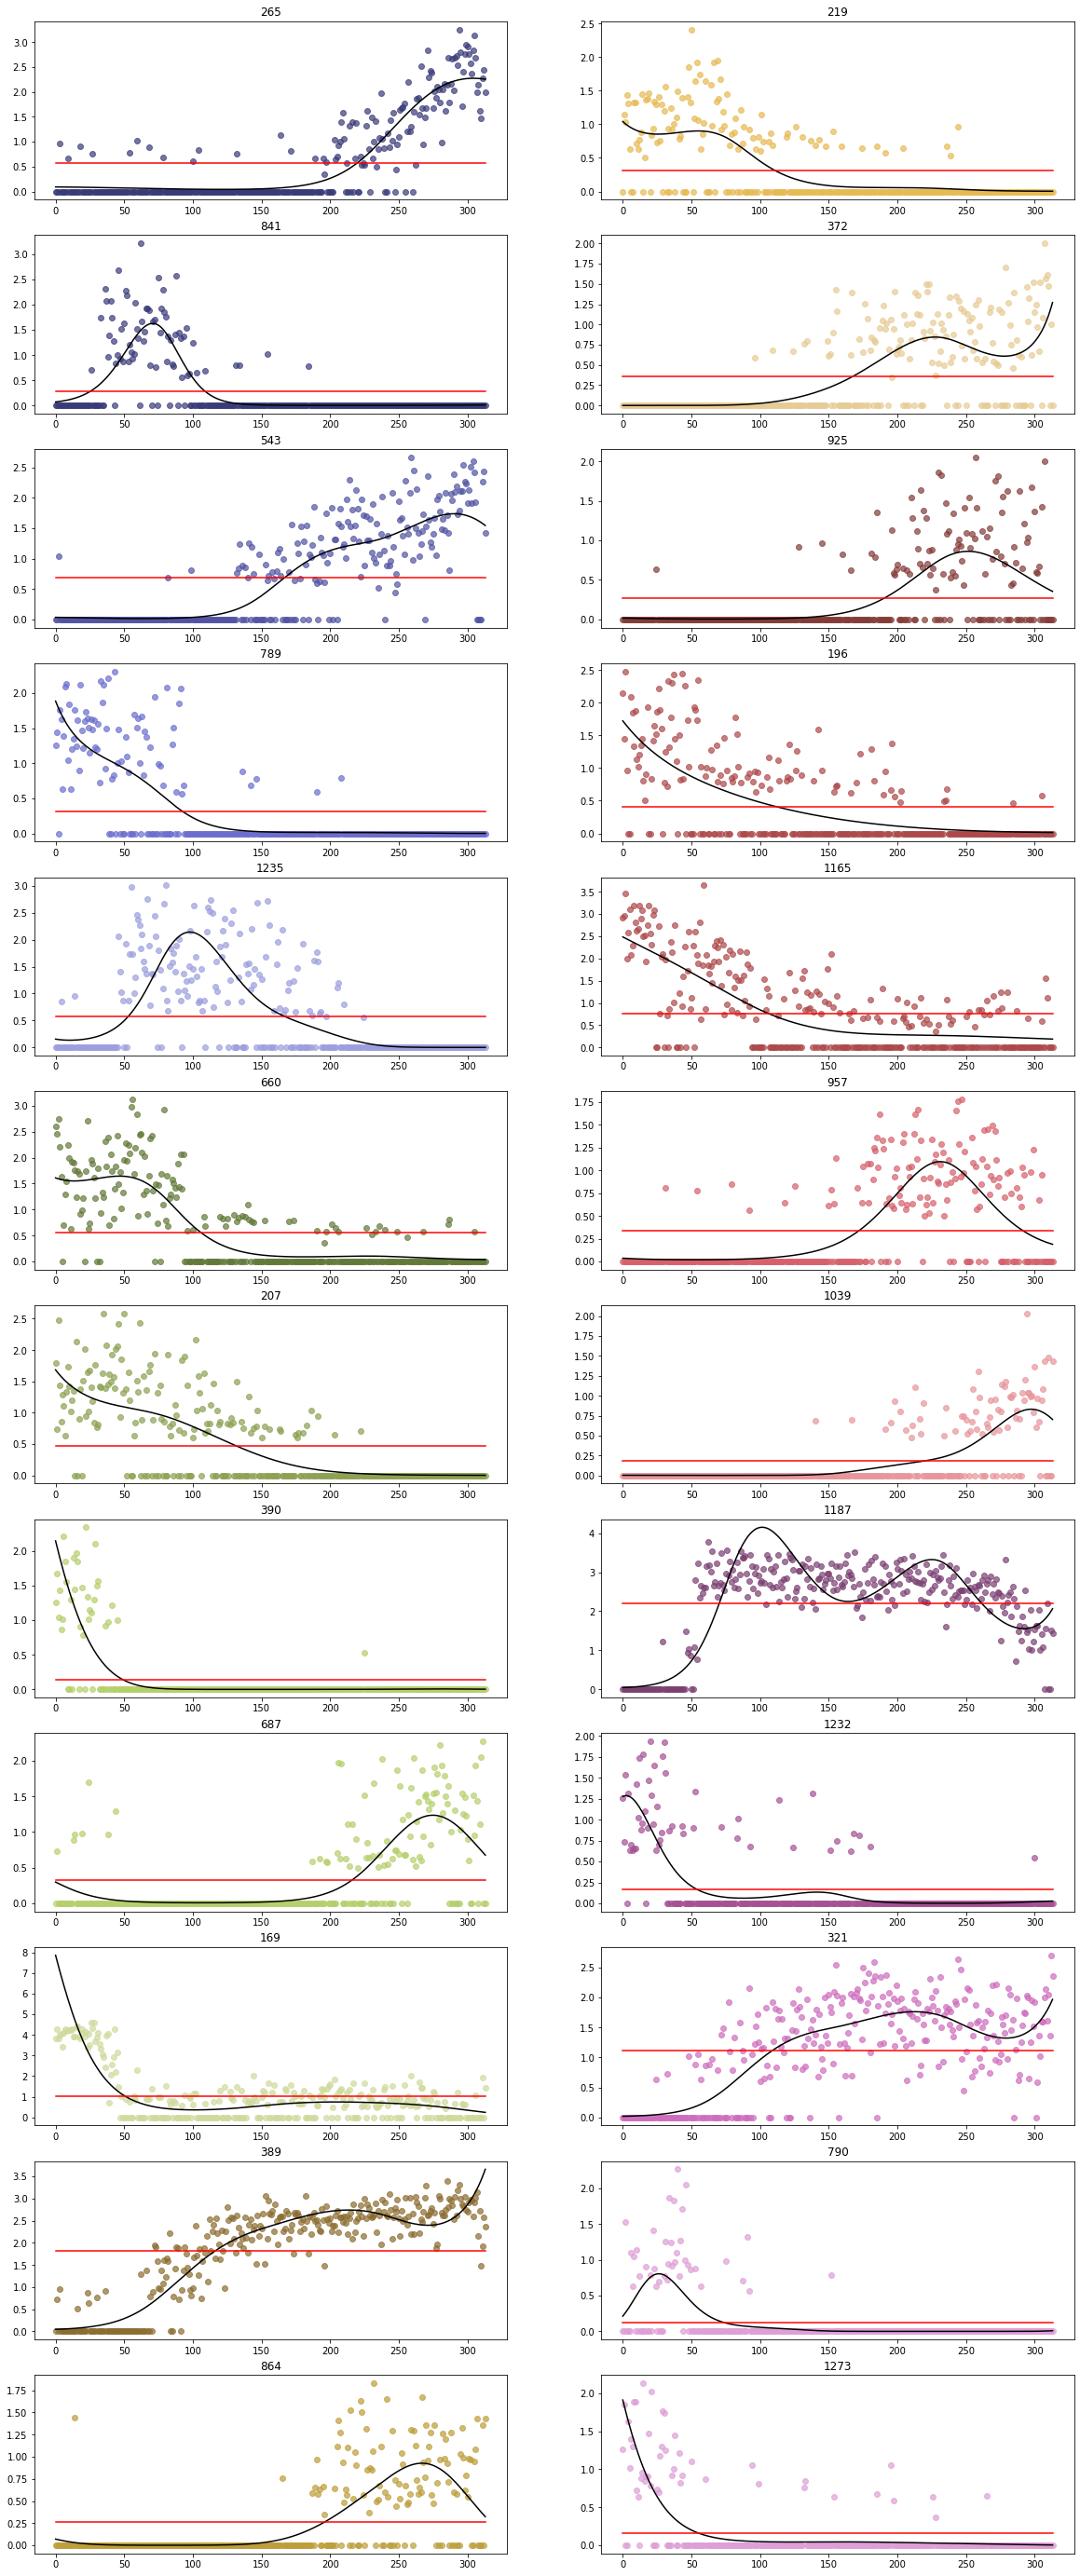

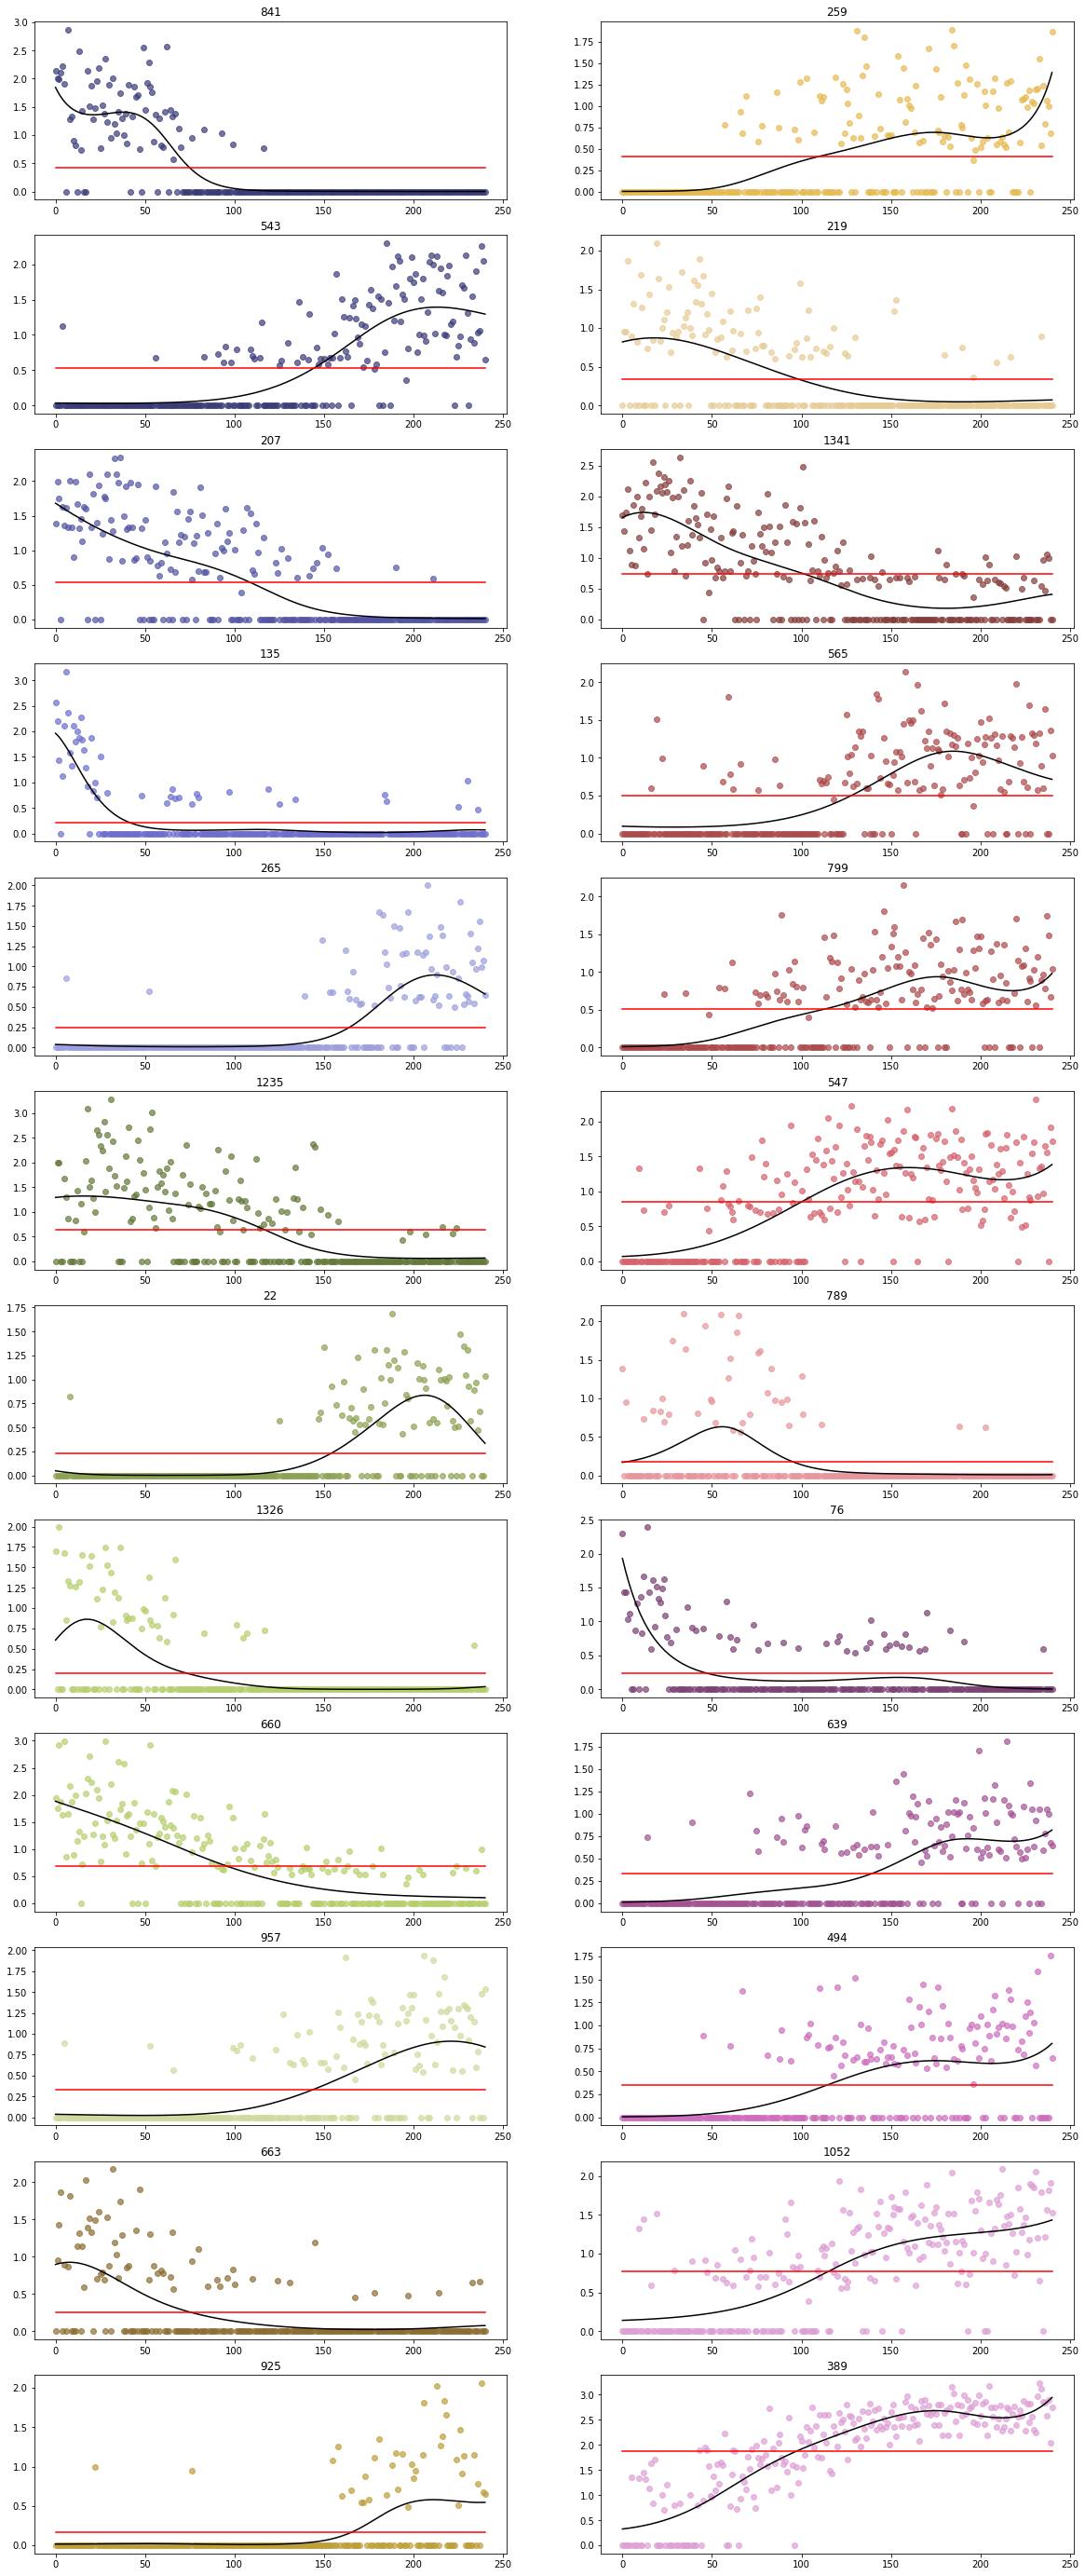

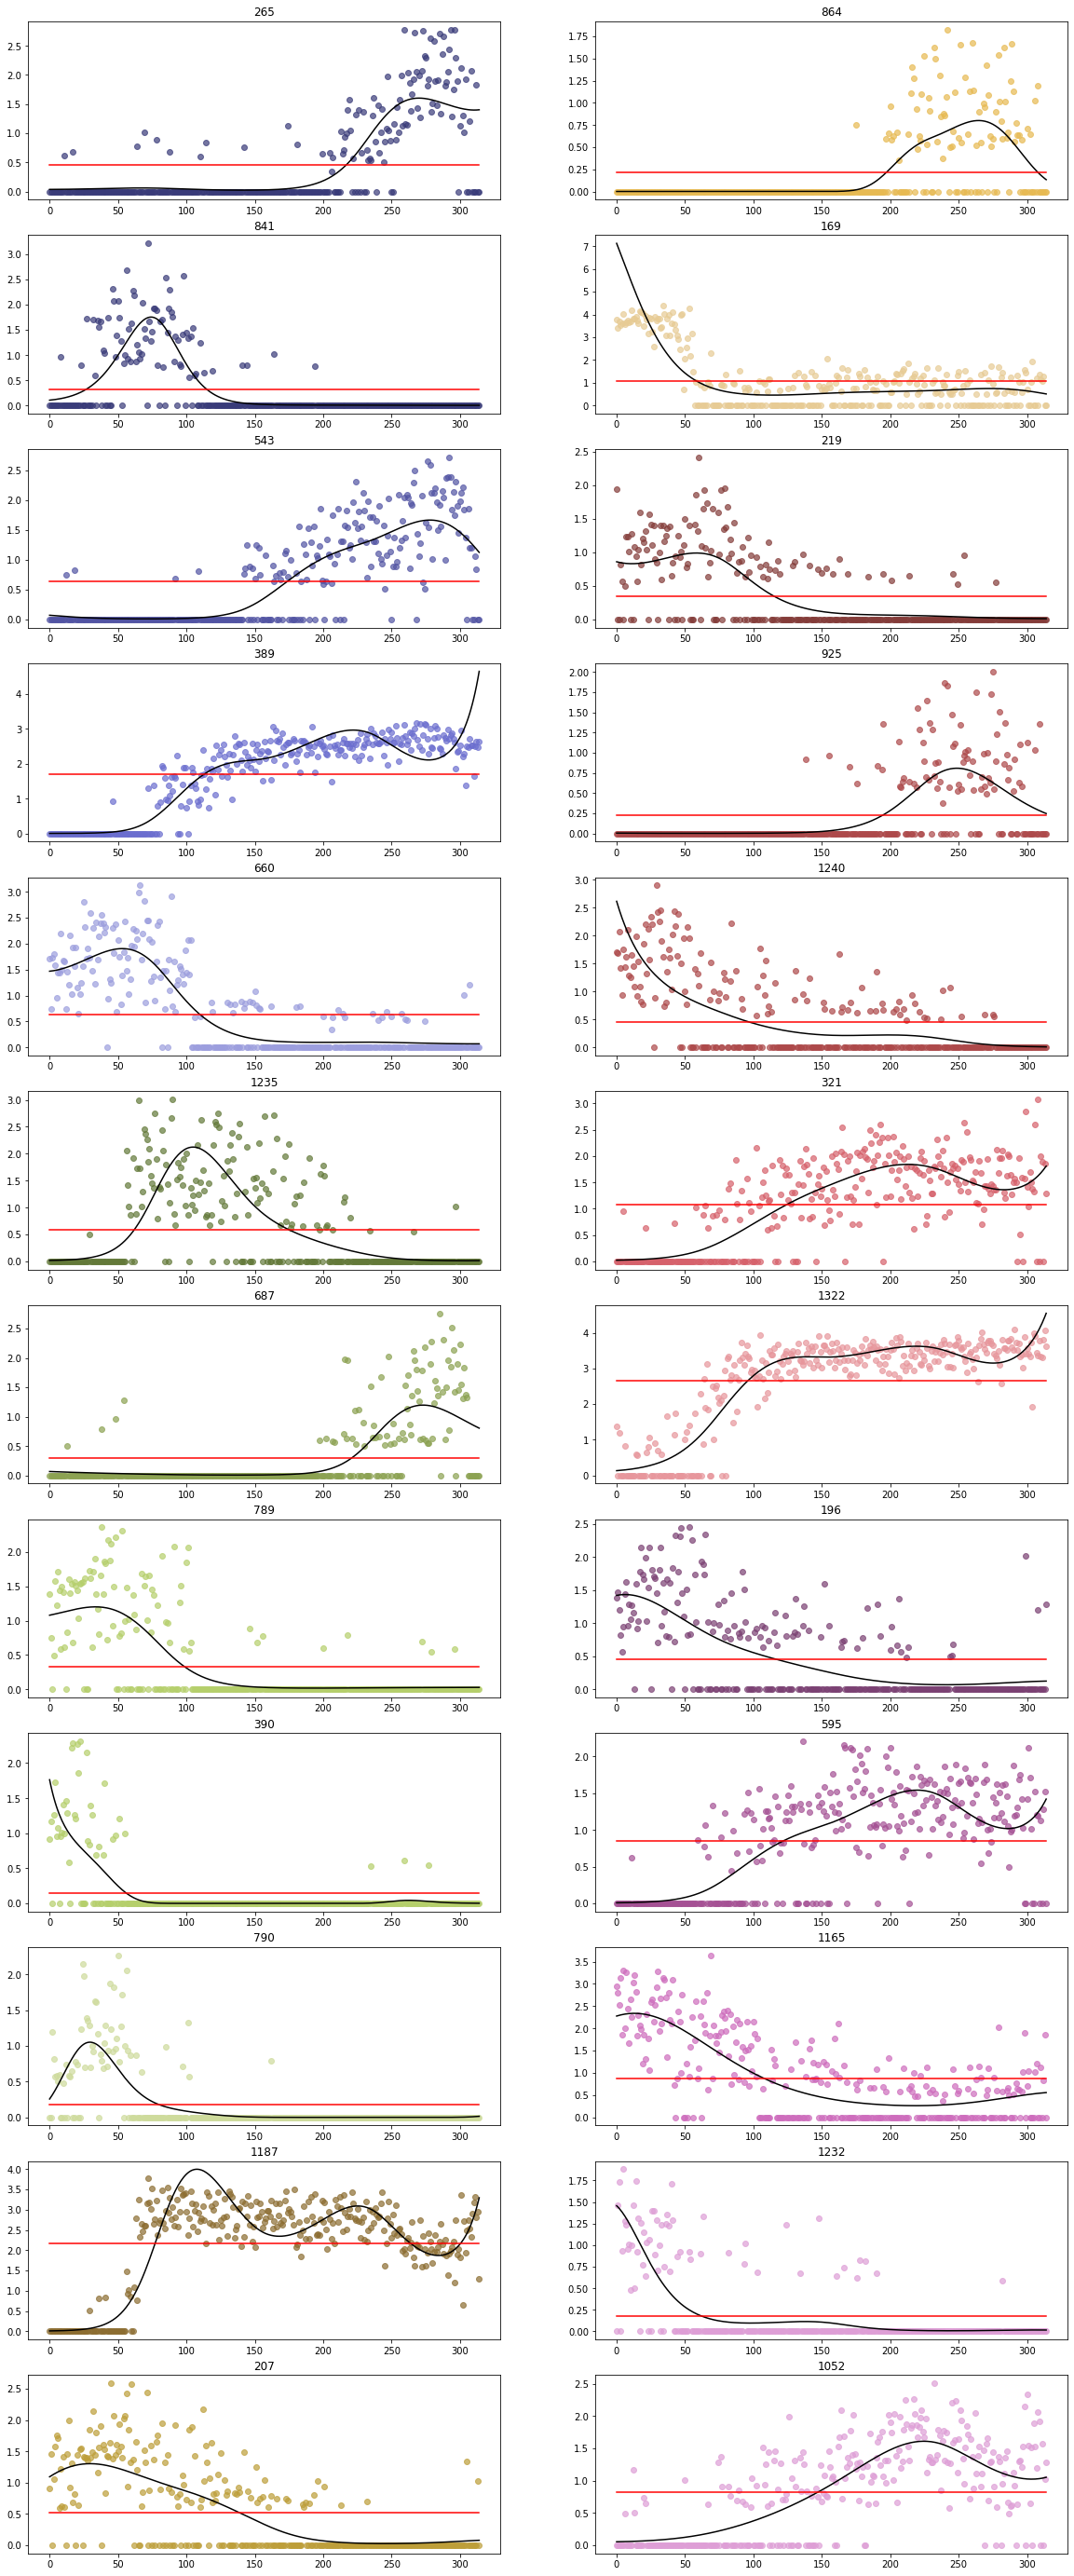

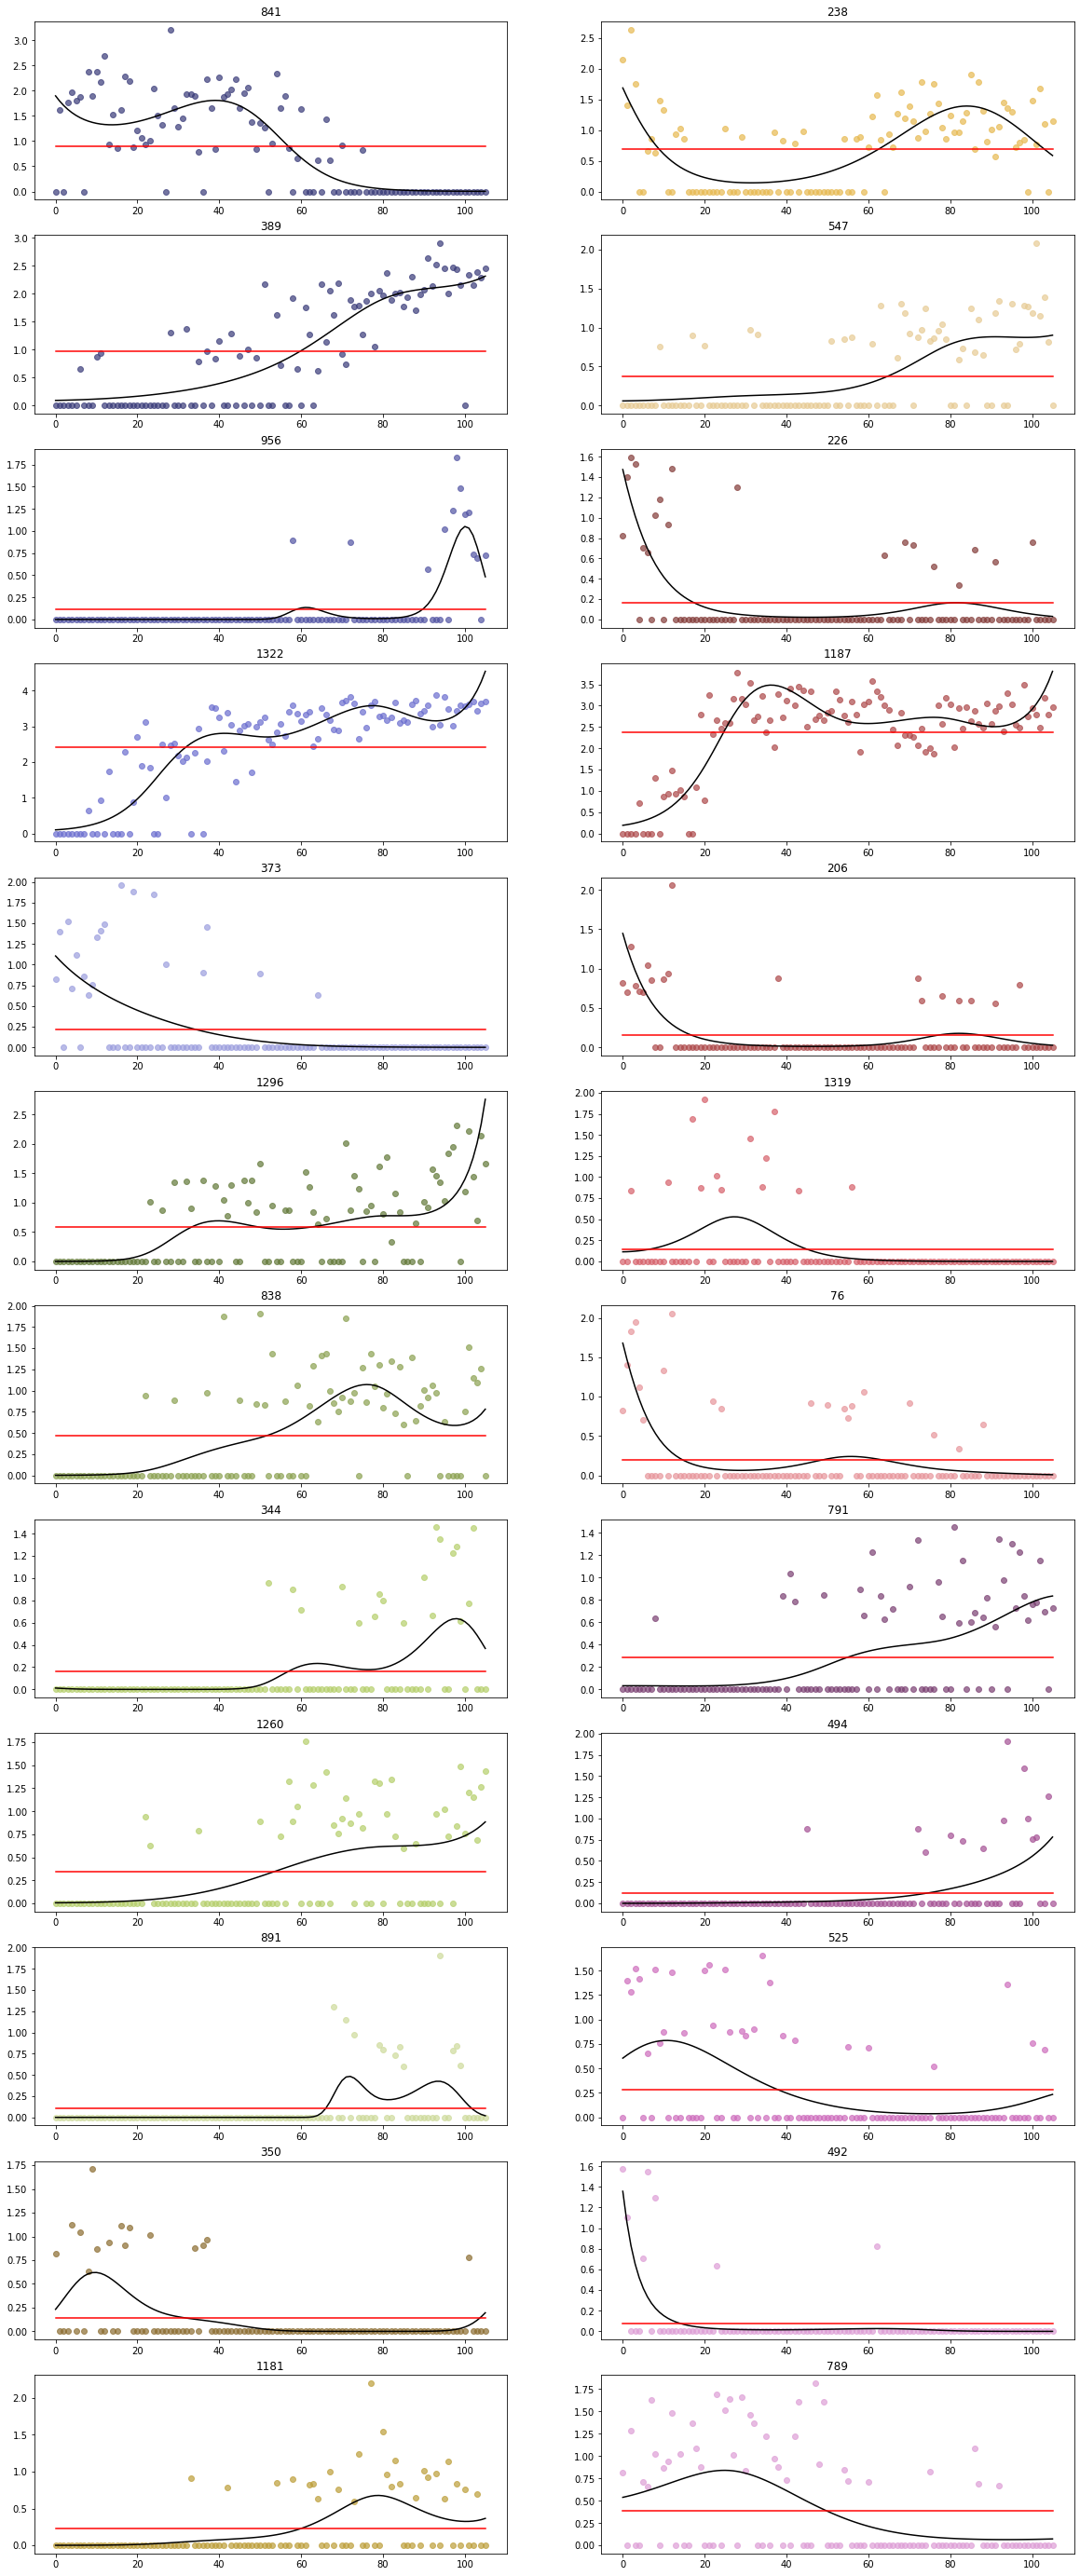

In [12]:
de.de_plot(adata, pseudo_order, de_genes, figsize = (20,50), n_genes = 24, prefix = "./real_results/forebrain/")

In [ ]:
de.de_heatmap(adata, pseudo_order, de_genes, figsize = (20, 10), n_genes = 20, prefix = "./real_results/dg/")

## GO plot

In [8]:
import pandas as pd

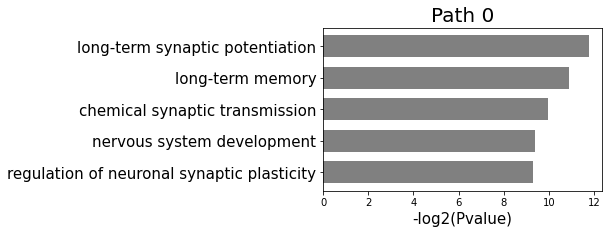

In [67]:
go1 = pd.read_csv("./real_results/dg/reconst_1/David/GO_bp_func_anno_chart.tsv", sep = "\t").iloc[:5]
func = go1['Term']
func = [x.split("~")[1] for x in func]
pval = go1['PValue']
pval = -np.log(pval)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot()
barWidth = 0.7
go = ax.barh(np.arange(len(func)), pval.values, height = barWidth, capsize = 7, color = 'gray')

ax.set_xlabel("-log2(Pvalue)", fontsize = 15)
plt.yticks(np.arange(len(func)), func, fontsize = 15)
plt.gca().invert_yaxis()
ax.set_title("Path 0", fontsize = 20)
fig.savefig(fname = "GO_path0.pdf", bbox_inches = 'tight')

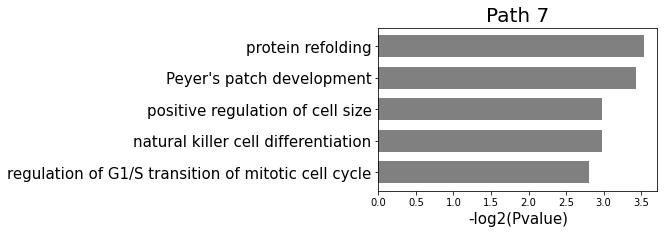

In [70]:
go1 = pd.read_csv("./real_results/dg/reconst_7/David/GO_chart.tsv", sep = "\t").iloc[:5]
func = go1['Term']
func = [x.split("~")[1] for x in func]
pval = go1['PValue']
pval = -np.log(pval)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot()
barWidth = 0.7
go = ax.barh(np.arange(len(func)), pval.values, height = barWidth, capsize = 7, color = 'gray')

ax.set_xlabel("-log2(Pvalue)", fontsize = 15)
plt.yticks(np.arange(len(func)), func, fontsize = 15)
plt.gca().invert_yaxis()
ax.set_title("Path 7", fontsize = 20)
fig.savefig(fname = "GO_path7.pdf", bbox_inches = 'tight')